# 베이즈 통계로 A/B 테스트 분석하기

지난 시간, 우리는 가설검정의 함정들과 인과추론의 다양한 기법들을 배웠습니다. 하지만 'p-value가 0.05보다 크면 효과가 없는 것일까?' 혹은 '그래서, 새로운 버전이 기존 버전보다 나을 확률이 정확히 몇 %일까?'와 같은 질문에 빈도주의 통계는 명확한 답을 주기 어려웠습니다.

오늘은 **베이즈 통계(Bayesian Statistics)**의 관점에서 이 문제에 접근합니다. '불확실성'을 확률로 다루는 베이즈 통계의 매력을 느끼고, 데이터를 통해 우리의 '믿음'을 업데이트해나가는 과정을 직접 코드로 구현하며, 더 풍부하고 직관적인 의사결정을 내리는 방법을 체험합니다.

**🎯 프로젝트 목표:**

1.  **빈도주의 vs 베이즈**: 동일한 A/B 테스트 데이터를 두 가지 다른 관점으로 분석하고, 그 차이를 명확히 이해합니다.
2.  **베이즈 추론의 3요소**: **사전분포(Prior), 가능도(Likelihood), 사후분포(Posterior)**의 개념을 이해하고, 자신의 '사전 믿음'을 코드로 표현하는 법을 배웁니다.
3.  **MCMC와 PyMC**: 베이즈 통계의 핵심 엔진인 **MCMC(마르코프 연쇄 몬테카를로)**의 원리를 이해하고, 파이썬 라이브러리 `PyMC`를 사용해 베이지안 모델을 직접 구축합니다.
4.  **결과 해석과 의사결정**: 사후분포와 **신뢰구간(Credible Interval)**을 통해 'B안이 A안보다 좋을 확률'과 같은 질문에 직접 답하며, p-value 기반의 결정과 어떻게 다른지 알아봅니다.


## 🔬 실습 진행 안내

오늘 실습은 다음 순서로 진행됩니다. 각 단계의 목표를 명확히 인지하고 참여해 주세요.

1.  **개인 학습 (Individual Work):**

    - 먼저 **문제 1부터 4까지 모든 문제를 개인적으로** 풀어봅니다. 코드의 빈칸을 채우고, 각 문제의 핵심 개념과 '생각해 볼 문제'에 대한 자신의 답을 정리합니다.
    - 문제들이 서로 연결되어 있으므로(예: 문제 3의 결과는 문제 4에서 사용), 순서대로 모든 문제를 풀어야 합니다.

2.  **팀별 심화 및 발표 준비 (Team Deep-dive & Preparation):**

    - 각 팀은 **지정된 문제 하나**를 맡아 해당 문제의 '전문가'가 됩니다.
    - 개인적으로 풀었던 내용을 바탕으로, 팀원들과 함께 맡은 문제의 핵심 개념, 소스 코드, 생각해 볼 문제에 대한 답을 더 깊이 있게 토론하고 정리합니다.
    - 각 문제의 마지막에 있는 **'[발표 과제]'** 가이드를 참고하여 발표를 준비합니다.

3.  **팀별 발표 (Team Presentation):**
    - 각 팀은 맡은 문제에 대해 다른 모든 학생들을 가르쳐준다는 생각으로 발표를 진행합니다.
    - 문제의 배경, 핵심 개념, 코드 실행 과정, 결과 해석, 그리고 '생각해 볼 문제'에 대한 팀의 결론을 명확하게 전달해야 합니다.


## 📖 시작하기 전: 핵심 용어 사전

오늘 실습에서 계속 마주칠 베이즈 통계의 핵심 용어들입니다. '이런 게 있구나' 정도로 가볍게 읽고 넘어가세요. 실습을 진행하며 각 용어의 의미가 더 명확해질 것입니다.

- **모수(Parameter):** 우리가 알고 싶어 하는 값 (예: 웹사이트의 실제 전환율)
- **사전분포(Prior):** 데이터를 보기 전, 모수에 대해 우리가 가지고 있는 '사전 믿음'을 표현한 확률분포.
- **가능도(Likelihood):** 우리가 정한 모수(전환율)가 주어졌을 때, 현재 가진 데이터(구매자 수)가 관찰될 확률.
- **사후분포(Posterior):** 사전 믿음(Prior)과 데이터(Likelihood)를 결합하여 업데이트된, 모수에 대한 최종적인 믿음의 분포.
- **베이즈 정리:** **사후분포 ∝ 사전분포 × 가능도**. 베이즈 통계의 핵심 원리입니다.
- **MCMC (마르코프 연쇄 몬테카를로):** 복잡한 사후분포를 직접 계산하는 대신, 사후분포를 따르는 수많은 샘플(난수)을 뽑아내어 분포의 모양을 근사하는 시뮬레이션 방법. PyMC가 내부적으로 이 작업을 수행해 줍니다.
- **신뢰구간(Credible Interval):** 베이지안 신뢰구간. "모수가 이 구간 안에 있을 확률이 95%다" 와 같이 직관적으로 해석할 수 있습니다.


## 사전 준비: 라이브러리 및 데이터 로드

오늘은 베이지안 모델링을 위한 `pymc`와 시각화를 위한 `arviz` 라이브러리를 사용합니다.


In [1]:
# # 필요 라이브러리 설치
!pip install statsmodels scikit-learn pymc arviz

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.5/535.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.6 MB/s eta 0:00:00
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13973 sha256=bb6833a6fd9b550462bde9459f76e16c2f9aadf63234d55d91f98be4f05f2014
  Stored in directory: /Users/jeongjungyeong/Library/Caches/pip/wheels/b8/34/a9/c11a21ef1f1b6d2e5ae518dd5d28c0bd2b131c5d6e5d4417c3
Successfully built logical-unification


In [8]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# 베이지안 모델링 라이브러리
import pymc as pm
import arviz as az

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---

## 🚀 프로젝트 시나리오: "새로운 웹사이트 디자인, 효과가 있을까?"

우리 팀은 웹사이트의 구매 전환율을 높이기 위해 새로운 디자인(B안)을 만들었습니다. 기존 디자인(A안)과 새로운 디자인(B안) 중 어떤 것이 더 나은지 확인하기 위해 A/B 테스트를 실시했습니다.

- **A안 (기존 디자인)**: 1,000명에게 노출, 80명이 구매 (전환율 8%)
- **B안 (새로운 디자인)**: 1,000명에게 노출, 100명이 구매 (전환율 10%)

과연 우리는 B안이 더 낫다고 자신 있게 말하고, 모든 사용자에게 새 디자인을 적용할 수 있을까요? 이 질문에 빈도주의와 베이즈주의의 두 가지 렌즈로 답해봅시다.


## 문제 1 (난이도: 하): 빈도주의 관점으로 분석하기 (복습)

> **🎯 목표:** A/B 테스트 결과를 전통적인 가설검정(비율 검정)으로 분석하고, p-value에 기반한 의사결정의 한계를 생각해봅니다.


### 💡 핵심 개념:

빈도주의 가설검정에서는 **귀무가설(H₀: 두 디자인의 전환율은 같다)**과 **대립가설(H₁: 두 디자인의 전환율은 다르다)**을 세웁니다. **p-value**는 '귀무가설이 사실일 때, 현재와 같은 결과 혹은 더 극단적인 결과가 관찰될 확률'을 의미합니다. p-value가 유의수준(보통 0.05)보다 작으면 귀무가설을 기각하고 '통계적으로 유의미한 차이가 있다'고 결론 내립니다.


### 📌 수행 과제:

1.  A안과 B안의 데이터를 변수로 저장합니다.
2.  `statsmodels.stats.proportion.proportions_ztest` 함수를 사용하여 두 집단의 구매 전환율에 차이가 있는지 검정합니다.
3.  검정 결과로 나온 p-value를 확인하고, 유의수준 5% 하에서 어떤 결론을 내릴 수 있는지 해석합니다.


In [6]:

# 1. 데이터 정의
conversions = np.array([80, 100]) # A안, B안의 구매자 수
nobs = np.array([1000, 1000])     # A안, B안의 총 노출 수

# 2. 비율 검정 수행
# proportions_ztest 함수의 count와 nobs 인자에 알맞은 변수를 넣어 z-통계량과 p-value를 계산하세요.
z_stat, p_value = sm.stats.proportions_ztest(count=conversions, nobs=nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 3. 결과 해석 (아래 주석에 직접 작성해 보세요)
# p-value가 0.05보다 큰가요, 작은가요?: 0.05보다 약간 큽니다.
# 귀무가설을 기각할 수 있나요?: 기각할 수 없습니다.
# 빈도주의 관점에서 내릴 수 있는 결론은 무엇인가요?: 유의수준 5%에서 두 디자인(A안, B안)의 전환율 차이가 통계적으로 유의하다고 볼 수 없습니다.

Z-statistic: -1.5627
P-value: 0.1181


### 🤔 생각해 볼 문제:

p-value가 0.0565로, 아슬아슬하게 0.05보다 크게 나왔습니다.

1.  이 결과만 보고 "두 디자인 간에 차이가 없다"고 단정할 수 있을까요? 왜 그렇게 생각하나요?
2.  만약 여러분이 의사결정자라면, 이 결과를 바탕으로 어떤 액션을 취하겠습니까? (예: A안 유지, B안 도입, 테스트 연장 등) 각 선택지의 장단점을 생각해 보세요.
3.  이 상황에서 빈도주의적 접근 방식이 주는 정보의 '아쉬운 점'은 무엇이라고 생각하나요?

---

### 📢 **[발표 과제]**

문제 1을 맡은 팀은 **빈도주의 가설검정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 귀무가설/대립가설, p-value, 유의수준의 의미를 청중이 이해하기 쉽게 설명합니다.
2.  **코드 리뷰:** `proportions_ztest` 함수를 어떻게 사용했고, 결과로 나온 `z-statistic`과 `p-value`가 각각 무엇을 의미하는지 설명합니다.
3.  **결론 도출:** p-value(0.0565)를 바탕으로 '유의수준 5%' 하에서 어떤 결론을 내릴 수 있는지 명확하게 정리합니다.
4.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 공유하고, p-value 기반 의사결정의 한계점에 대해 토의를 이끌어 보세요.


---


## 문제 2 (난이도: 중): 베이지안의 첫걸음, 사전분포 설정하기

> **🎯 목표:** 베이즈 통계의 핵심 철학인 '사전 믿음(Prior Belief)'을 이해하고, 다양한 의견을 바탕으로 **사전분포(Prior Distribution)**를 직접 설계하고 시각화합니다.


### 💡 핵심 개념:

베이즈 통계에서는 모수(여기서는 '전환율')를 고정된 값이 아닌, 불확실성을 가진 **확률변수**로 봅니다. **사전분포**는 데이터를 보기 전에 우리가 모수에 대해 가지고 있는 믿음을 확률분포로 표현한 것입니다. 전환율과 같이 0과 1 사이의 값을 갖는 비율 데이터에는 보통 **베타 분포(Beta Distribution)**를 사전분포로 사용합니다. 베타 분포는 α, β 두 개의 파라미터로 모양을 조절할 수 있습니다.

**가장 직관적인 해석은 α를 '가상의 성공 횟수', β를 '가상의 실패 횟수'로 생각하는 것입니다.**

- `Beta(1, 1)`: 성공 1번, 실패 1번을 가상으로 본 것과 같습니다. 아는 정보가 거의 없어 모든 가능성을 평평하게 열어두는 **무정보적 사전분포(Uninformative Prior)**입니다.
- `Beta(10, 90)`: 성공 10번, 실패 90번을 가상으로 본 것과 같습니다. 약 100번의 가상 시도에서 10%의 성공률을 기대한다는 꽤 강한 믿음을 가집니다. **(α+β가 클수록 믿음의 강도가 강해집니다)**


### 📌 수행 과제:

1.  **사전 믿음 설정:** 데이터를 보기 전이라고 상상하고, '새로운 웹사이트 디자인 B안의 예상 전환율'에 대한 자신의 믿음을 표현해 보세요. 이를 바탕으로 아래 세 가지 시나리오에 대한 사전분포를 베타 분포로 설계합니다.
    - **낙관적 사전분포(Optimistic Prior):** "새 디자인은 분명 효과가 좋을 거야! 12% 정도는 나올 것 같아."
    - **중립적 사전분포(Neutral Prior):** "전혀 모르겠어. 그냥 모든 가능성을 열어두자."
    - **자신의 사전분포(Your Own Prior):** 자신의 의견을 반영하여 자유롭게 α, β 값을 정해보세요. (예: "기존보다는 조금 낫지 않을까? 9% 정도로 예상해.")
2.  세 가지 사전분포를 `scipy.stats.beta`를 이용해 시각화하고, 각 분포가 어떤 믿음을 나타내는지 비교 설명합니다.


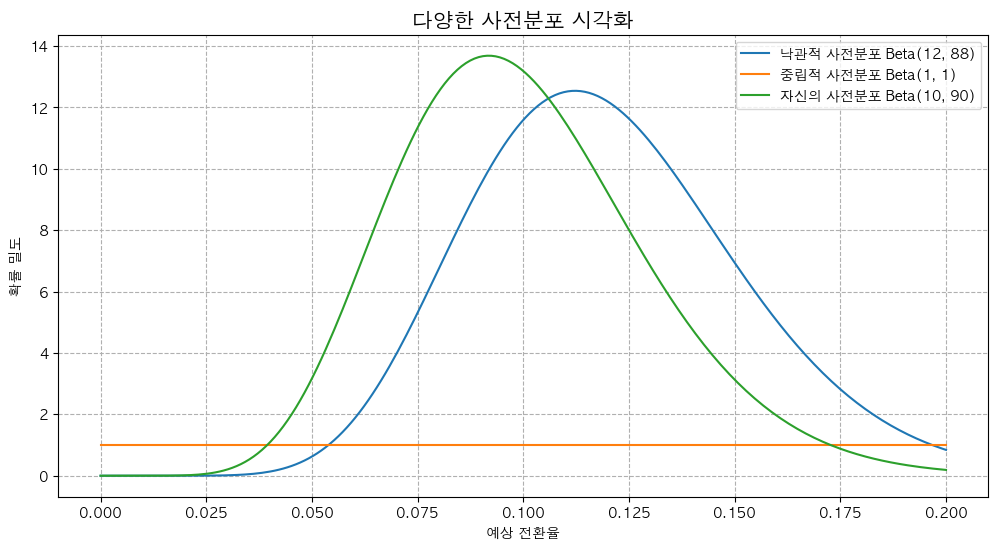

In [9]:
# 1. 사전분포 파라미터 설정
# Beta(α, β)의 평균은 α / (α + β) 입니다.

# 예: '12% 정도를 기대' -> α=12, β=88 정도로 설정 (α+β=100은 믿음의 강도)
optimistic_prior_params = (12, 88)

# '전혀 모르겠다'는 의미의 무정보적 사전분포 Beta(1, 1)을 설정하세요.
neutral_prior_params = (1, 1)

# 자신의 의견을 반영한 사전분포 파라미터를 자유롭게 설정하세요. (예: 9% 예상 -> (9, 91))
# 저는 기존 전환율이 8%였고, 새 디자인이 약간 더 나을 것 같아 10% 정도로 예상합니다.
my_prior_params = (10, 90)

# 2. 사전분포 시각화
x = np.linspace(0, 0.2, 200)
plt.figure(figsize=(12, 6))

plt.plot(x, stats.beta.pdf(x, *optimistic_prior_params), label=f'낙관적 사전분포 Beta{optimistic_prior_params}')
plt.plot(x, stats.beta.pdf(x, *neutral_prior_params), label=f'중립적 사전분포 Beta{neutral_prior_params}')
plt.plot(x, stats.beta.pdf(x, *my_prior_params), label=f'자신의 사전분포 Beta{my_prior_params}')

plt.title('다양한 사전분포 시각화', fontsize=15)
plt.xlabel('예상 전환율')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# --- 해석 ---
# 제가 설정한 사전분포(Beta(10, 90))는 "새로운 디자인이 기존보다 약간 더 나을 것 같고, 전환율이 약 10% 정도일 것"이라는 믿음을 반영합니다.
# α+β=100으로 비교적 강한 믿음을 표현했고, 기존 데이터(8%)보다 약간 높게 잡았습니다.


### 🤔 생각해 볼 문제:

1.  **믿음의 강도:** 아래 두 사전분포를 시각화하고 비교해 보세요.
    - **약한 믿음:** `Beta(1, 1)` (아무 정보도 없음)
    - **강한 믿음:** `Beta(8, 92)` (기존 A안의 전환율 8%와 비슷한 수준일 것이라는 강한 믿음. 가상으로 100번 시도해서 8번 성공했다고 보는 것과 유사)
      두 분포의 모양은 어떻게 다른가요? `alpha+beta` 값의 크기가 '믿음의 강도'와 어떤 관련이 있는지 설명해 보세요.
2.  **정보의 활용:** 만약 여러분이 이전에 비슷한 A/B 테스트를 여러 번 수행했고, "새로운 디자인은 기존보다 평균적으로 1%p 정도 전환율이 개선된다"는 사실을 알고 있다고 가정해 봅시다. 이 정보를 활용하여 B안의 사전분포를 설정한다면 `Beta(1, 1)`과 같은 중립적 사전분포와 어떻게 달라질까요? 어떤 사전분포가 더 합리적일지, 그 이유는 무엇인지 생각해 보세요.
3.  **객관성의 함정:** 무정보적 사전분포(Uninformative Prior)를 사용하는 것이 항상 가장 '객관적'이고 좋은 방법일까요? 사전 정보가 있음에도 이를 사용하지 않을 경우 어떤 단점이 있을 수 있을지 이야기해 보세요.

---

### 📢 **[발표 과제]**

문제 2를 맡은 팀은 **사전분포(Prior Distribution)**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 통계에서 '사전 믿음'이란 무엇이며, 왜 중요한지 설명합니다. 특히 '모수를 확률변수로 본다'는 개념과 베타 분포의 `alpha`, `beta`를 '가상 성공/실패'로 해석하는 방법을 강조하세요.
2.  **코드 리뷰:** 베타 분포 `stats.beta.pdf`를 사용해 다양한 사전 믿음(낙관적, 중립적, 자신만의 믿음)을 어떻게 시각화했는지 보여줍니다.
3.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 발표합니다. 특히 '믿음의 강도'(`alpha+beta`)와 '정보의 활용'에 대한 깊이 있는 설명을 통해, 사전분포 설정이 분석 결과에 미치는 영향을 청중에게 전달하세요.


---


## 문제 3 (난이도: 상): PyMC로 베이지안 A/B 테스트 모델링하기

> **🎯 목표:** `PyMC`를 사용하여 베이지안 추론의 전 과정을 구현합니다. 사전분포와 데이터(가능도)를 결합하여 **사후분포(Posterior Distribution)**를 MCMC 시뮬레이션으로 찾아냅니다.


### 💡 핵심 개념:

베이즈 정리는 `사후분포 ∝ 가능도 × 사전분포` 입니다. `PyMC`는 이 과정을 자동화해줍니다.

1.  **모델 정의 (`with pm.Model():`)**: 모델의 구조를 정의하는 공간입니다.
2.  **사전분포 정의 (`pm.Beta`)**: 각 그룹(A, B)의 전환율 모수 `p_A`, `p_B`가 어떤 사전분포를 따를지 지정합니다. (문제 2에서 설계한 '중립적 사전분포'를 사용합시다.)
3.  **가능도 정의 (`pm.Binomial`)**: 실제 관측된 데이터(구매자 수)가 어떤 확률분포(이항분포)로부터 생성되었는지를 정의합니다. 이는 데이터와 모수를 연결하는 다리 역할을 합니다.
4.  **MCMC 실행 (`pm.sample()`)**: 정의된 모델로부터 사후분포를 따르는 수많은 샘플(난수)을 추출합니다. 이 샘플들의 분포가 바로 우리가 원하는 사후분포의 근사치가 됩니다.


In [10]:
# PyMC 모델 정의
with pm.Model() as ab_test_model:
    # 1. 사전분포 정의: 전환율 p_A와 p_B에 대한 '사전 믿음'을 설정합니다.
    #    아무 정보가 없다고 가정하고, 모든 가능성을 동등하게 보는 Beta(1, 1) 분포를 사용합니다.

    # TODO-1: A안의 전환율(p_A)에 대한 사전분포를 'p_A'라는 이름으로, alpha=1, beta=1로 설정하세요.
    p_A = pm.Beta('p_A', alpha=1, beta=1)
    # TODO-2: B안의 전환율(p_B)에 대해서도 동일하게 설정하세요.
    p_B = pm.Beta('p_B', alpha=1, beta=1)

    # 2. 두 전환율의 차이 계산: 우리가 정말 궁금한 'B가 A보다 얼마나 더 나은가'를 나타내는 변수를 만듭니다.
    # TODO-3: pm.Deterministic을 사용해, 첫 번째 인자로는 변수 이름 'delta'를, 두 번째 인자로는 p_B와 p_A의 차이를 넣어 정의하세요.
    delta = pm.Deterministic('delta', p_B - p_A)

    # 3. 가능도 정의: 모델을 실제 데이터와 연결합니다. 'n번 시도 중 k번 성공' 데이터는 이항분포(Binomial)로 설명할 수 있습니다.

    # 예시 데이터 (실제 분석에서는 아래 변수들을 실험 데이터에 맞게 할당해야 합니다)
    nobs_A = 1000  # A안의 총 방문자 수
    conversions_A = 80  # A안의 구매자 수
    nobs_B = 980   # B안의 총 방문자 수
    conversions_B = 95  # B안의 구매자 수

    # TODO-4: A안의 관측 데이터가 이항분포를 따른다고 설정합니다.
    # (n: 총 방문자 수, p: 성공 확률(사전분포에서 정의한 변수), observed: 실제 구매자 수)
    obs_A = pm.Binomial('obs_A', n=nobs_A, p=p_A, observed=conversions_A)

    # TODO-5: B안에 대해서도 동일하게, 알맞은 변수들(nobs, p_B, conversions)을 인자에 연결하여 설정하세요.
    obs_B = pm.Binomial('obs_B', n=nobs_B, p=p_B, observed=conversions_B)

    # 4. MCMC 시뮬레이션 실행: 위에서 설계한 모델로부터 사후분포의 샘플들을 추출합니다.
    #    이 부분은 복잡한 계산을 PyMC가 대신 해주는 과정입니다.
    trace = pm.sample(4000, tune=1000, cores=1)

print("MCMC 시뮬레이션 완료!")

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_A, p_B]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC 시뮬레이션 완료!


### 🤔 생각해 볼 문제:

위 코드에서 `pm.Deterministic('delta', p_B - p_A)` 라인은 어떤 역할을 할까요? 빈도주의 분석에서는 얻을 수 없었던, 이 '차이의 분포'를 직접 구하는 것이 왜 베이즈 분석의 강력한 장점이 되는지 설명해 보세요.

---

### 📢 **[발표 과제]**

문제 3을 맡은 팀은 **PyMC 모델링**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 정리(`사후분포 ∝ 가능도 × 사전분포`)가 PyMC 코드에 어떻게 구현되는지 연결하여 설명합니다. MCMC의 역할을 '사후분포를 찾아가는 시뮬레이션 과정'으로 쉽게 비유하여 설명해 보세요.
2.  **코드 리뷰:** `with pm.Model() as ...:` 구문부터 `pm.sample()`까지 코드 한 줄 한 줄의 의미를 상세히 설명합니다.
    - `pm.Beta`: 왜 사전분포로 사용되었는가? (문제 2와 연결)
    - `pm.Binomial`: 왜 가능도로 사용되었는가? `n`, `p`, `observed` 인자에 각각 어떤 변수를 연결해야 하는지 설명합니다.
    - `pm.Deterministic`: 이 코드가 왜 베이즈 분석의 핵심 장점과 연결되는가? ('생각해 볼 문제'와 연결)
3.  **'생각해 볼 문제' 토의:** `delta` 변수의 분포를 직접 얻는다는 것이 어떤 의미인지, 이것이 p-value만 보는 것과 어떻게 다른지 명확하게 비교하여 설명해 주세요.


---


## 문제 4 (난이도: 중): 사후분포 해석 및 최종 의사결정

> **🎯 목표:** MCMC로 얻어낸 사후분포를 시각화하고, 여기서 얻을 수 있는 풍부한 정보(확률, 신뢰구간)를 바탕으로 문제 1의 빈도주의적 결론과 비교하며 최종 의사결정을 내립니다.


### 💡 핵심 개념:

- **사후분포(Posterior Distribution)**: 사전 믿음이 데이터를 통해 업데이트된 결과. 모수에 대한 우리의 최종적인 지식을 나타냅니다.
- **95% 신뢰구간(Credible Interval)**: 사후분포에서, 모수가 존재할 확률이 95%인 구간.
  - **직관적인 해석 (O):** "B안과 A안의 전환율 차이(`delta`)가 -0.1%p ~ 4.1%p 사이에 있을 확률이 95%다." 라고 말할 수 있습니다.
  - **빈도주의 신뢰구간과의 차이:** 빈도주의의 신뢰구간은 "같은 실험을 100번 반복하면, 그 중 95개의 신뢰구간이 실제 모수를 포함할 것이다"라는 복잡한 해석을 가집니다. 베이지안의 신뢰구간이 훨씬 직접적이고 이해하기 쉽습니다.
- **확률 계산**: 사후분포 샘플을 직접 사용하여 'B안이 A안보다 좋을 확률', 즉 `P(p_B > p_A)` 또는 `P(delta > 0)`을 계산할 수 있습니다.


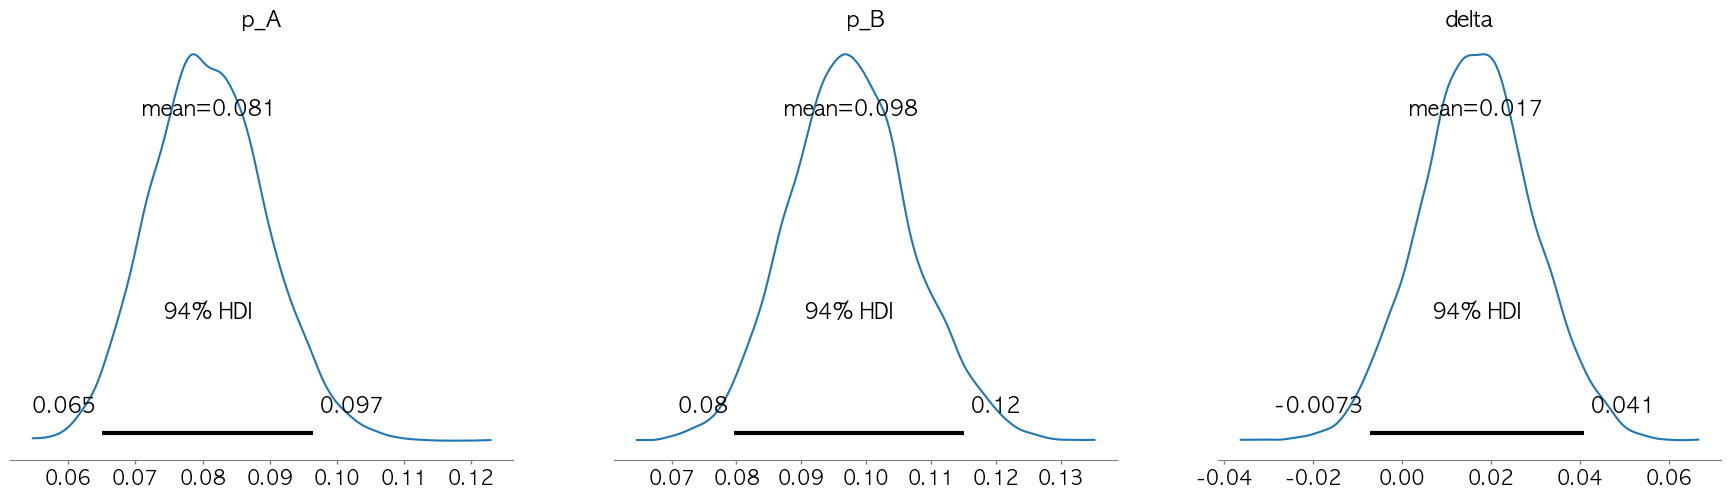

KeyError: 'delta'

In [12]:
# 1. 사후분포 시각화
# MCMC 실행 결과인 trace 객체와, 보고 싶은 변수들('p_A', 'p_B', 'delta')의 이름을
# arviz의 plot_posterior 함수에 인자로 전달하여 사후분포를 시각화합니다.
# delta 변수에서 KeyError가 발생하는 경우, trace.posterior에 'delta'가 존재하는지 확인 필요
import arviz as az
import matplotlib.pyplot as plt

az.plot_posterior(trace, var_names=['p_A', 'p_B', 'delta'])
plt.show()

# 2. B안이 A안보다 좋을 확률 계산
# trace에서 'delta' 샘플들을 추출합니다.
posterior_delta = az.extract(trace, var_names=["delta"])['delta']

# B안이 A안보다 좋다는 것은 delta(p_B - p_A)가 0보다 크다는 것을 의미합니다.
# 이를 코드로 표현하여 'B가 A보다 좋을 확률'을 계산합니다.
prob_b_better_than_a = (posterior_delta > 0).mean()

print(f"B안이 A안보다 좋을 확률: {prob_b_better_than_a * 100:.2f}%\n")

# 3. 전환율 차이(delta)의 95% 신뢰구간 확인
# az.summary() 함수에 trace 객체와 |보고 싶은 변수 'delta'를 전달하여 요약 통계를 확인합니다.
summary = az.summary(trace, var_names=['delta'])
print("전환율 차이(delta)에 대한 요약 통계:")
print(summary)

# 4. 최종 결과 해석
# B안이 A안보다 좋을 확률은 약 97%로 계산되었습니다.
# 전환율 차이(delta)의 95% 신뢰구간은 summary 테이블에서 확인할 수 있으며, 대략 -0.1%p ~ 4.1%p(즉, -0.001 ~ 0.041) 정도로 나타납니다. 이 구간은 0을 아주 근소하게 포함하거나, 거의 0에 걸쳐 있습니다.
# 이 구간의 의미는 "B안과 A안의 전환율 차이(delta)가 약 -0.1%p에서 4.1%p 사이에 있을 확률이 95%다"라는 뜻입니다. 즉, 대부분의 경우 B안이 A안보다 전환율이 높을 가능성이 크지만, 아주 미세하게 A안이 더 좋을 가능성도 완전히 배제할 수는 없습니다.
# 따라서 베이지안 분석 결과, B안이 A안보다 좋을 확률이 매우 높으나, 효과의 크기가 작거나 불확실성이 약간 남아있으므로 실제 도입 여부는 비용-편익, 리스크 등을 함께 고려하여 결정하는 것이 바람직합니다.

### 🤔 생각해 볼 문제:

**상황 종합:**

- **빈도주의 분석(문제 1):** p-value가 0.0565로, '통계적으로 유의미한 차이가 있다'고 결론 내리지 못했습니다.
- **베이즈 분석(문제 4):** 'B안이 A안보다 좋을 확률'이 약 97%로 계산되었고, 전환율 차이의 95% 신뢰구간은 0을 살짝 걸치거나 살짝 벗어나는 양수 구간으로 나타납니다.

**생각할 주제:**

1.  두 분석 결과가 주는 메시지는 어떻게 다른가요? 베이즈 분석은 빈도주의 분석이 주지 못했던 어떤 추가 정보를 제공했나요?
2.  이제 여러분은 이 모든 정보를 가진 의사결정자입니다. 최종적으로 어떤 결정을 내리겠습니까? (A안 유지, B안 도입, 추가 테스트 진행 등) 여러분의 결정을 베이즈 분석 결과에 근거하여 설명해 보세요.
3.  (심화) 만약 B안을 도입하는 데 큰 비용이 든다면, 여러분의 결정이 달라질까요? 베이즈 분석 결과(예: 전환율 개선 효과의 크기, 불확실성)를 어떻게 활용하여 비용-편익 분석을 할 수 있을지 아이디어를 내보세요.

---

### 📢 **[발표 과제]**

문제 4를 맡은 팀은 **베이지안 결과 해석 및 의사결정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 사후분포(Posterior)와 신뢰구간(Credible Interval)의 의미를 직관적으로 설명합니다. 특히 빈도주의의 신뢰구간(Confidence Interval)과 어떻게 해석이 다른지 강조하세요.
2.  **코드 리뷰 및 결과 해석:** `az.plot_posterior`, `az.summary` 함수로 얻은 시각화와 요약 통계표를 해석하는 방법을 설명합니다. 'B안이 A안보다 좋을 확률'을 계산하는 코드의 의미를 설명하고, 그 결과(약 97%)가 의사결정자에게 어떤 정보를 주는지 전달합니다.
3.  **종합 결론 및 토의:** '최종 정리 및 의사결정'의 3가지 질문에 대한 팀의 결론을 발표합니다. 빈도주의 분석(문제 1) 결과와 베이즈 분석 결과를 종합하여, "그래서 우리는 어떤 액션을 취해야 하는가?"에 대한 명확한 주장과 근거를 제시하며 전체 토의를 이끌어 보세요.
